# House Sale Prediction

This is the final Machine Learning project finished by Heqing Chen and Yiqing Wang.

Our goals are to:

    ·Try to build a linear regression model to predict House Sale with several related features.
    ·Use sevaral techniques we learned from lecture and resources online to make comparison among different results.


## Loading data

First we import some packets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew

%matplotlib inline

Now we load the data from cvs files, which contain training data and test data.

The data files can be found in www.kaggle.com, and we read it by panda library.

In [2]:
train = pd.read_csv("train.csv", index_col = 0)
test = pd.read_csv("test.csv", index_col = 0)

We print the shape of those two data, and we will get the number of samples and the number of features of each sample in these two parts.

In [3]:
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


Try to see the features and data clearly by the following command

In [4]:
train.head()
#test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


With the command .head(), we can clearly see some parts of the features. Also, we have found that in the test part, it does not contain HouseSale feature, which needs to be predicted.


## Data pre-processing

As we have seen some parts of the data above, we need to preprocessing the data. The method and of preprocessing and the code are referred from https://www.kaggle.com/bsivavenu/house-price-calculation-methods-for-beginners/notebook and https://www.kaggle.com/apapiu/regularized-linear-models/notebook

In order to preprocess the data efficiently, we first combine those two data into one part.

In [5]:
X = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                test.loc[:,'MSSubClass':'SaleCondition']))

We will show the target features data in different types below.

From online resource, we found that transform the original numeric data into log data will make the data seems more normal. So we decide to do that.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000272314F3438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000272325BAF28>]], dtype=object)

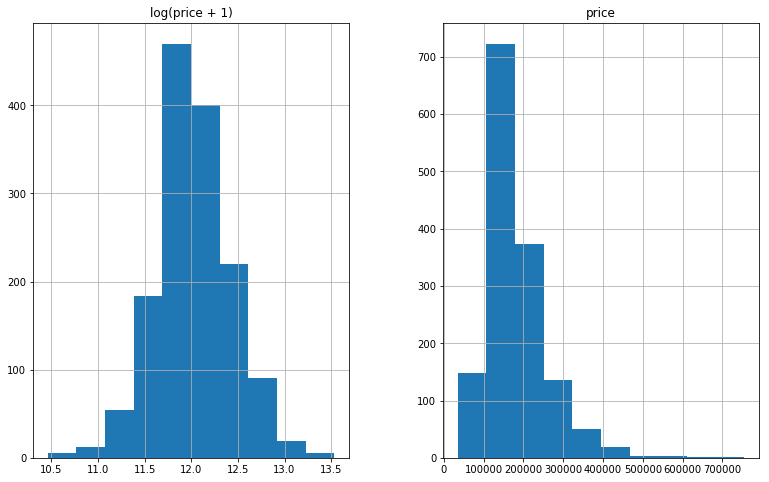

In [6]:
matplotlib.rcParams['figure.figsize'] = (13.0, 8.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

From the figures, after transforming the feature by taking log(feature + 1), the feature seems more like normal distribution.

As there are many kinds of features, we need to scale the features that may have large effect on the result. In the begining, we filter some features which have the 'object' type of data that can not be categorical. Since the features are not totally in normal distribution and most features' weight are lower than mean level which means the weight distribution tends to left, we need to compute all the categorical features' skewness. If the features have large skewness, that means they have enough weight to influence the house sale result. So we choose some features with large skewness and transform them to log type. 

The related concepts are in statistics. And the skew() method can be refered in https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html.

In [7]:
# log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

# log transform skewed numeric features:
numeric_feats = X.dtypes[X.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewness = skewed_feats[skewed_feats > 0.75]
X_Index = skewness.index

X[X_Index] = np.log1p(X[X_Index])
print(X_Index)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


Now we have all the features we need. But it not enough, we still need to do some works.

We convert the categorical variable into dummy variables which is like one-hot code we learnt from the lecture. Then we fill on the missing data which is NAN with the mean value of the related column. 

In [8]:
# convert categorical variable into dummy/indicator variables, like one-hot code
X = pd.get_dummies(X) 

# filling NAN's with the mean of the column:
X = X.fillna(X.mean())

## Multi-Linear Regression with no regularization

Now we try to fit linear regression model with no regularization.

In [9]:
# creating matrices for sklearn:
nt = train.shape[0]
ntr = nt // 2
nts = nt - ntr
X_train = X[:nt]
xtr = X_train[:ntr]
xts = X_train[ntr:]
y_train = train.SalePrice
ytr = y_train[:ntr]
yts = y_train[ntr:]

X_test = X[nt:]

We have created matices for sklearn. We divided the data into original training and test parts.

Also, in order to make sure that the linear model works well, we divided the training and test data into their own two parts: one for training, another one for testing. And the number of samples of each part is the half of the whole training data samples.

We fit xtr and ytr to linear regression with no regularization.

In [10]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(xtr, ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now we make the prediction with xts, and measure the accurancy by compute the normalized RSS.

In [11]:
yts_hat = regr.predict(xts)
RSS = np.mean((yts_hat - yts)**2) / (np.std(yts)**2)
print(RSS)

0.1819290900891748


Plot the figure of the linear regression.

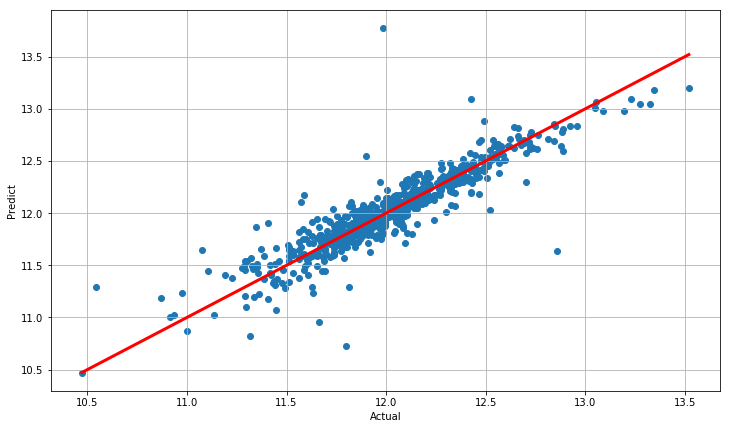

In [12]:
ymin = np.min(yts)
ymax = np.max(yts)
plt.scatter(yts, yts_hat)
plt.plot([ymin, ymax], [ymin, ymax], 'r-', linewidth = 3)
plt.grid()
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.show()

It seems good, but we try to set regularization to avoid overfit

## Using Ridge regularizaion

Ridge regression is L2 regression, which is also contained in the lecture, and we try to use it with K-fold cross validation to see if it works well by using the whole training data.

We firstly need to fit the Ridge model with different value of alpha.

In [13]:
import  sklearn.model_selection
Xs = sklearn.preprocessing.scale(X_train)
ys = sklearn.preprocessing.scale(y_train)

nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Create the Ridge model.
model_ridge = linear_model.Ridge()

# Regularization values to test
nalpha = 100
alphas = np.logspace(-1,5,nalpha)

# MSE for each alpha and fold value
rss = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(Xs)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    Xs_tr = Xs[Itr,:]
    ys_tr = ys[Itr]
    Xs_ts = Xs[Its,:]
    ys_ts = ys[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Fit the model on the training data
        model_ridge.alpha = a
        model_ridge.fit(Xs_tr,ys_tr)
        
        # Compute the prediction error on the test data
        ys_ts_pred = model_ridge.predict(Xs_ts)
        rss[ia,ifold] = np.mean((ys_ts_pred-ys_ts)**2) / (np.std(ys_ts)**2)

Plot the mean test RSS and test RSS standard error with the plt.errorbar() plot. Also, find the optimal alpha and mean test RSS using the one standard error rule. 

Normalized RSS with Ridge = 0.108817
The optimal alpha = 1149.756995


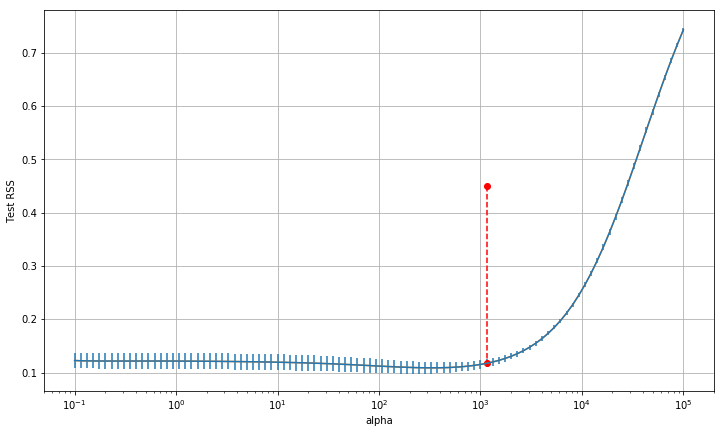

In [14]:
rss_mean = np.mean(rss,axis=1)
rss_std  = np.std(rss,axis=1) / np.sqrt(nfold-1)

# Find the minimum MSE and MSE target
imin = np.argmin(rss_mean)
rss_tgt = rss_mean[imin] + rss_std[imin]
alpha_min = alphas[imin]
print("Normalized RSS with Ridge = %f" % rss_mean[imin])

# Find the least complex model with mse_mean < mse_tgt
I = np.where(rss_mean < rss_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("The optimal alpha = %f" % alpha_opt)

plt.errorbar(alphas, rss_mean, yerr=rss_std)
plt.semilogx([alpha_opt,alpha_opt], [0.45,rss_mean[iopt]], 'ro--')
plt.semilogx(alphas, rss_mean)
plt.xlabel('alpha')
plt.ylabel('Test RSS')
plt.grid()

The test normalized RSS seems better than before. The value of alpha is large

We use the optimal alpha to recompute the predict variable on the whole data and measure the accuracy of the Ridge model.

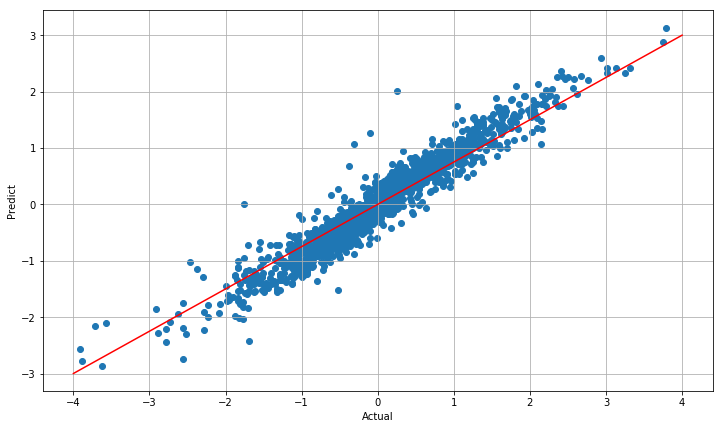

The normalized RSS of Ridge model: 0.080842


In [15]:
model_ridge.alpha = alpha_opt        
model_ridge.fit(Xs,ys)
ys_pred = model_ridge.predict(Xs)
rss = np.mean((ys_pred-ys)**2) / (np.std(ys)**2)
plt.scatter(ys,ys_pred)
plt.plot([-4,4],[-3,3],'r')
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.grid()
plt.show()
print('The normalized RSS of Ridge model: %f'% rss)

After adding Ridge regularization with K-fold cross validation, the normalized RSS decreases obviously and the accurancy gets improved.

## Using Lasso regularization

Lasso regularization is L1 regularization. We try to use Lasso regularization with K-fold cross validation to see if it has the same effect which Ridge regularization has.

We do the same work what we did before in Ridge regularization part.

In [16]:
# Create the LASSO model.
model_Lasso = linear_model.Lasso(warm_start=True)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-3,0,nalpha)

# MSE for each alpha and fold value
rss = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(Xs)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    Xs_tr = Xs[Itr,:]
    ys_tr = ys[Itr]
    Xs_ts = Xs[Its,:]
    ys_ts = ys[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Fit the model on the training data
        model_Lasso.alpha = a
        model_Lasso.fit(Xs_tr,ys_tr)
        
        # Compute the prediction error on the test data
        ys_ts_pred = model_Lasso.predict(Xs_ts)
        rss[ia,ifold] = np.mean((ys_ts_pred-ys_ts)**2) / (np.std(ys_ts)**2)

Then we need to find the optimal alpha by finding the position where the normalized RSS is smallest.

Optimal alpha = 0.037649
Normalized RSS with Lasso = 0.101390


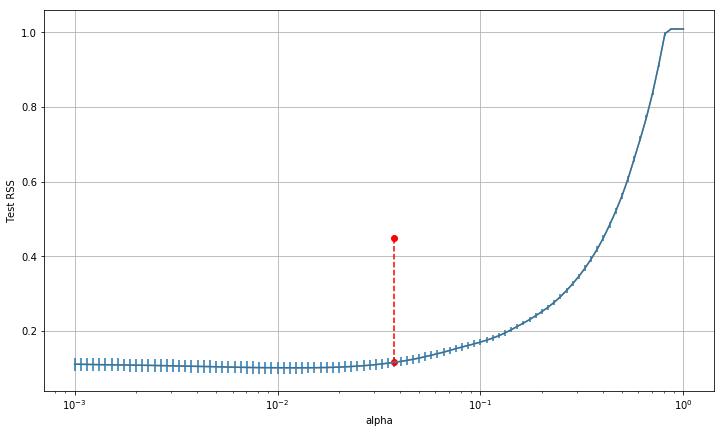

In [17]:
rss_mean = np.mean(rss,axis=1)
rss_std  = np.std(rss,axis=1) / np.sqrt(nfold-1)

# Find the minimum MSE and MSE target
imin = np.argmin(rss_mean)
rss_tgt = rss_mean[imin] + rss_std[imin]
alpha_min = alphas[imin]

# Find the least complex model with mse_mean < mse_tgt
I = np.where(rss_mean < rss_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt)
print("Normalized RSS with Lasso = %f" % rss_mean[imin])

plt.errorbar(alphas, rss_mean, yerr=rss_std, fmt='-')
plt.semilogx([alpha_opt,alpha_opt], [0.45,rss_mean[iopt]], 'ro--')
plt.semilogx(alphas, rss_mean,)
plt.xlabel('alpha')
plt.ylabel('Test RSS')
plt.grid()
plt.show()

The test normalized RSS is a little larger than that in Ridge model, and the alpha is much smaller which is about 0.03.

Finally we use the optimal alpha to fit the data to the lasso model and measure the accurancy of this model.

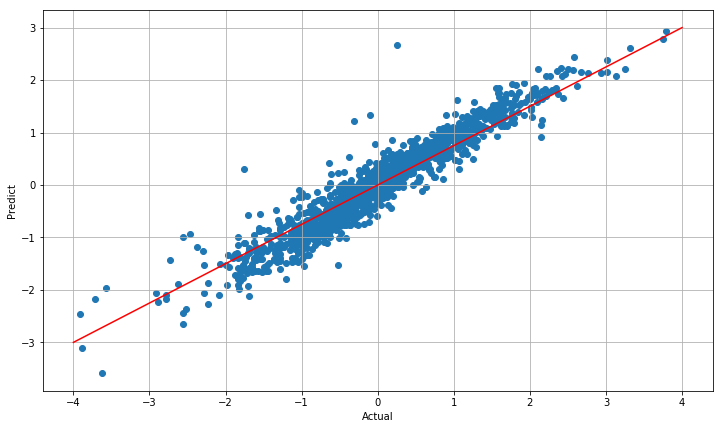

The normalized RSS of Lasso model: 0.096999


In [18]:
# The result seems better
model_Lasso.alpha = alpha_opt        
model_Lasso.fit(Xs,ys)
ys_pred = model_Lasso.predict(Xs)
rss = np.mean((ys_pred-ys)**2) / (np.std(ys)**2)
plt.scatter(ys,ys_pred)
plt.plot([-4,4],[-3,3],'r')
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.grid()
plt.show()
print('The normalized RSS of Lasso model: %f'% rss)

The result is almost the same as what the Ridge regularization have.

## Conclusion

From this project that we have done, we have those conclusions:
    
    ·Multi-linear regression model can be used to predict house sale with high accurancy.
    ·Both the Ridge regularization and Lasso regularization with K-fold cross validation could have great effect on predicting the house sale data.
    ·It seems that Ridge regularization and Lasso Regularization have the same effect on increasing the accurancy of prediction, and we can  fit the test.csv data to both these two model.

## Extra part

Finally, we try to find which features of the data can have best effect and worst effect on the price prediction by using Lasso regression model.

We use Series() method in panda library to get the label-based index which can be reflected directly to the feature. Some information could be found in https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html. Then we find the largest ten coefficients and smallest coefficients and combine them together and plot them. 

The method is cited from https://www.kaggle.com/apapiu/regularized-linear-models/notebook.

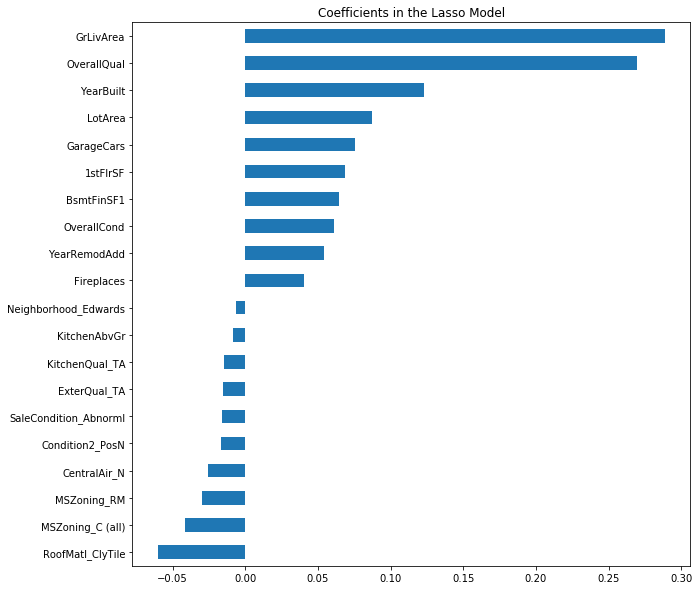

In [19]:
# Take a look at the coefficients with LASSO regression model:
coef = pd.Series(model_Lasso.coef_, index = X_train.columns)
# Combine 10 positive values and 10 negative values together:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
# horizontal bar plot
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is GrLivArea - the above ground area by area square feet. And the second one is OverallQual - the overall quality. And other important features are clearly shown above.